### About

### 1. Configuration of the environment

list of various authentification attributes

auth_url : https://identity.open.softlayer.com
project : object_storage_91969bbb
project_id : e1a709ad10c7403b904ae3fce7380670
region : dallas
user_id : 24685c90698c4a20b60c164a97acfec7
domain_id : 62a2c69643d249758de71492cd05a5f1
domain_name : 815561
username : user_23bdd4594e70bec4cd7dd7bb1ed172da6979e78d
password : Tk3[U{h.#o{yM840
filename : nyt1.csv
container : notebooks
tenantId : se5a-8f37553c9ef3aa-e65d03030f05


In [286]:
# credentials dictionary for the data source 

credentials = {}
credentials['name'] = 'ClickThroughs'
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['project_id'] = 'e1a709ad10c7403b904ae3fce7380670'
credentials['region'] = 'dallas'
credentials['user_id'] = '24685c90698c4a20b60c164a97acfec7'
credentials['password'] = 'Tk3[U{h.#o{yM840'

In [287]:
# defining the configuration function

def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name']
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v2.0/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [288]:
# running the function to enable connection to the data source

set_hadoop_config(credentials)

### 2. Import dataset and libraries

In [289]:
# importing required SQL content library 
# Main entry point for Spark SQL functionality.

from pyspark.sql import SQLContext

In [290]:
# A SQLContext is used create DataFrames

sqlContext = SQLContext(sc)

In [291]:
# import the file with the first day of click data, format is now in RDD
clicks = sc.textFile("swift://notebooks.ClickThroughs/nyt1.csv")

In [292]:
# sanity check, is the number of lines (obervations) as expected ?
clicks.count()

458442

In [293]:
# importing Row to enable transformation to DataFrame

from pyspark.sql import Row

### 3. Initial dataset transformations

In [294]:
# use of map function to conver every line into a sequence of component elements split by comma

clicks2 = clicks.map(lambda l: l.split(","))

In [295]:
# the first two csv rows from the orginal file where the lines are not seperated
clicks.take(2)

[u'"Age","Gender","Impressions","Clicks","Signed_In"', u'36,0,3,0,1']

In [296]:
# the first two rows after the map transformation with the lines now separated in tuple form
clicks2.take(2)

[[u'"Age"', u'"Gender"', u'"Impressions"', u'"Clicks"', u'"Signed_In"'],
 [u'36', u'0', u'3', u'0', u'1']]

In [297]:
# the first line corresponds to the header

header = clicks2.first()

# data without header by using a filter
clicks_no_header = clicks2.filter(lambda line:line != header)

In [298]:
# checking that the header has been removed
clicks_no_header.first()

[u'36', u'0', u'3', u'0', u'1']

### 4. From RDD to Spark DataFrame

In [299]:
# mapping each line to a row and then all rows to a dataframe
df = clicks_no_header.map(lambda line: Row(Age = line[0], Gender = line[1], 
                              Impressions=line[2], Clicks=line[3], Signed_In=line[4])).toDF()

In [300]:
# this is an attempt to put the ages in to brackets, however the implementation with the below syntax cannot be
# applied rowwise and therefore the result is not the expected. 

def AgetoBuckets(age):
    if age in range(0,26):
        return str('0-25')
    if age in range(26,41):
        return str('26-40')
    else:
        return str('40+')
    
df_age_brackets = clicks_no_header.map(lambda line: Row(Age = AgetoBuckets(line[0]), Gender = line[1],
                              Impressions=line[2], Clicks=line[3], Signed_In=line[4])).toDF()

In [301]:
# insepcting the first row after the transformation

df.first()

Row(Age=u'36', Clicks=u'0', Gender=u'0', Impressions=u'3', Signed_In=u'1')

In [302]:
# 5 head rows 
df.head(5)

[Row(Age=u'36', Clicks=u'0', Gender=u'0', Impressions=u'3', Signed_In=u'1'),
 Row(Age=u'73', Clicks=u'0', Gender=u'1', Impressions=u'3', Signed_In=u'1'),
 Row(Age=u'30', Clicks=u'0', Gender=u'0', Impressions=u'3', Signed_In=u'1'),
 Row(Age=u'49', Clicks=u'0', Gender=u'1', Impressions=u'3', Signed_In=u'1'),
 Row(Age=u'47', Clicks=u'0', Gender=u'1', Impressions=u'11', Signed_In=u'1')]

In [303]:
# the names of the columns of the DF

df.columns

['Age', 'Clicks', 'Gender', 'Impressions', 'Signed_In']

In [304]:
# the show method presents data in a more readble, tabular format. 

df.show(3)

+---+------+------+-----------+---------+
|Age|Clicks|Gender|Impressions|Signed_In|
+---+------+------+-----------+---------+
| 36|     0|     0|          3|        1|
| 73|     0|     1|          3|        1|
| 30|     0|     0|          3|        1|
+---+------+------+-----------+---------+



### 5. Exploratory Analysis and experimentation with Spark DFs


In [305]:

# Check the schema of the DF 
df.printSchema()  

# all columns are of type string 

root
 |-- Age: string (nullable = true)
 |-- Clicks: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Impressions: string (nullable = true)
 |-- Signed_In: string (nullable = true)



In [306]:
# filter out males and show first 5 observations

df_filtered = df[df.Gender == 0]
df_filtered.show(5)


+---+------+------+-----------+---------+
|Age|Clicks|Gender|Impressions|Signed_In|
+---+------+------+-----------+---------+
| 36|     0|     0|          3|        1|
| 30|     0|     0|          3|        1|
| 47|     1|     0|         11|        1|
|  0|     1|     0|          7|        0|
| 46|     0|     0|          5|        1|
+---+------+------+-----------+---------+



In [307]:
# selecting a subset of the columns 
df.select('Age','Gender').show(10)


+---+------+
|Age|Gender|
+---+------+
| 36|     0|
| 73|     1|
| 30|     0|
| 49|     1|
| 47|     1|
| 47|     0|
|  0|     0|
| 46|     0|
| 16|     0|
| 52|     0|
+---+------+



In [308]:
# ask for the distribution of gender in the dataset- it turns out the majoriry (almost double in number) are males

df.groupBy("Gender").count().show()

+------+------+
|Gender| count|
+------+------+
|     0|290176|
|     1|168265|
+------+------+



In [309]:
# Most of the users are logged in

df.groupBy("Signed_In").count().show()

+---------+------+
|Signed_In| count|
+---------+------+
|        0|137106|
|        1|321335|
+---------+------+



In [310]:
# Looking at summary descriptive statistics across all variables 

df.describe(['Age', 'Gender','Clicks','Impressions', 'Signed_In']).show()


+-------+------------------+-------------------+-------------------+------------------+-------------------+
|summary|               Age|             Gender|             Clicks|       Impressions|          Signed_In|
+-------+------------------+-------------------+-------------------+------------------+-------------------+
|  count|            458441|             458441|             458441|            458441|             458441|
|   mean| 29.48255064446679|0.36703741593792877|0.09259424876919822|  5.00731609956352| 0.7009298906511416|
| stddev|23.607008035813386|0.48199683737503574|0.30997286137693547|2.2393464381293193|0.45785060777825803|
|    min|                 0|                  0|                  0|                 0|                  0|
|    max|                99|                  1|                  4|                 9|                  1|
+-------+------------------+-------------------+-------------------+------------------+-------------------+



In [311]:
# re-creating the dataframe in order to change the data types to integers that will enable 
# the use of functions like correlation

df = clicks_no_header.map(lambda line: Row(Age = int(line[0]), Gender = int(line[1]), 
                              Impressions=int(line[2]), Clicks=int(line[3]), Signed_In=line[4])).toDF()                        


In [312]:
df.printSchema()  # to check if the type change has taken place 


root
 |-- Age: long (nullable = true)
 |-- Clicks: long (nullable = true)
 |-- Gender: long (nullable = true)
 |-- Impressions: long (nullable = true)
 |-- Signed_In: string (nullable = true)



In [313]:
# Calculate correlation index between impressions and clicks

df.corr("Impressions", "Clicks", method=None)   

0.13515601142562947

In [314]:
# group by and apply function to see the average age by gender

df.groupBy("Gender").avg('Age').collect()     

[Row(Gender=0, AVG(Age)=22.90613282973092),
 Row(Gender=1, AVG(Age)=40.823700710189286)]

In [315]:
# the avg number of clicks based on whether users where loggin or not

df.groupBy("Signed_In").avg('Clicks').collect()     

[Row(Signed_In=u'0', AVG(Clicks)=0.14207985062652254),
 Row(Signed_In=u'1', AVG(Clicks)=0.07147991970996001)]

In [316]:
# number of observations broken down by age

df.groupBy('Age').count().show(10) 

+---+-----+
|Age|count|
+---+-----+
| 31| 6439|
| 32| 6443|
| 33| 6431|
| 34| 3290|
| 35| 3932|
| 36| 7933|
| 37| 7983|
| 38| 7891|
| 39| 7804|
| 40| 7702|
+---+-----+



In [317]:
# grouping by gender and producing the sum for clicks and mean for impressions

df.groupBy('Gender').agg({'Clicks': 'sum', 'Impressions': 'mean'}).collect()

[Row(Gender=0, AVG(Impressions)=5.006554642699603, SUM(Clicks)=30672),
 Row(Gender=1, AVG(Impressions)=5.0086292455353165, SUM(Clicks)=11777)]

In [319]:
#df.select("Gender", "Signed_In").groupBy("Gender").count().show()

#sliceddf = df[df.Age.inSet([30, 31, 32]) 
#                          & (df.Gender > 0)][['Age', 'Gender']]
#sliceddf.show()


### Plotting

In [320]:
# importing pandas library to use  its DataFrame plot method, as a wrapper to plt.plot

import pandas as pd

# to have figures by the matplotlib library rendered in line:

%matplotlib inline

In [321]:
# group by age, count group size and convert to pandas DataFrame

ageBreakDown = df.groupBy('Age').count().toPandas()

ageBreakDown.head()

,Age,count
0,31,6439
1,32,6443
2,33,6431
3,34,3290
4,35,3932


In [322]:
ageBreakDown.describe()

,Age,count
count,101.000000,101.000000
mean,55.980198,4539.019802
std,29.477103,13627.802515
min,0.000000,1.000000
25%,31.000000,283.000000
50%,56.000000,2502.000000
75%,81.000000,6394.000000
max,108.000000,137106.000000


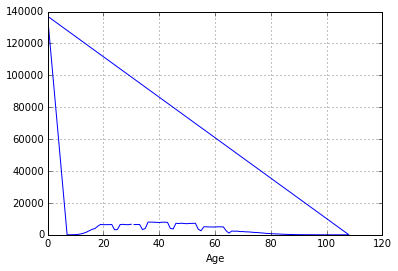

In [323]:
ageBreakDown.plot(x="Age", y="count")

# there is an outlier  at age value zero  (also the diagonal line is somehow unexpected)

In [326]:
# Introducing a new column for the Click-Through-Rate as the ratio of Clicks to Impressions for the Ads

df3 = df.withColumn('CTR', df["Clicks"]/df["Impressions"] )  

In [327]:
# transform into pandas and use the numpy method to calculate the mean across all variables

import numpy as np

pandasDF = df3.toPandas()
pandasDF = pandasDF.groupby('Signed_In').aggregate(np.mean)

In [328]:
# table with the outcome

pandasDF

,Age,Clicks,Gender,Impressions,CTR
Signed_In,,,,,
0,0.000000,0.14208,0.000000,4.999657,0.028355
1,42.062054,0.07148,0.523644,5.010584,0.014254


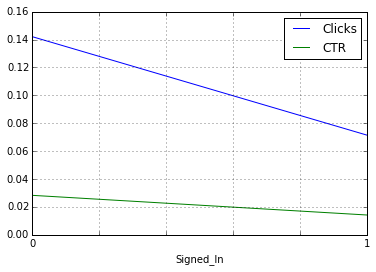

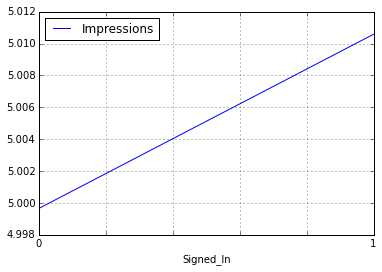

In [338]:

# plotting the differences between signedin and not, with pandas plot function 

pandasDF[["Clicks", "CTR"]].plot()

pandasDF[["Impressions"]].plot()


